# SIGMA - finer bins \begin{equation*} \frac{\partial V}{\partial t} = \Psi + \Omega \end{equation*}
## **ECCO**

In [23]:
from dask_gateway import GatewayCluster

cluster = GatewayCluster()
cluster.scale(30)
#cluster.adapt(minimum=2, maximum=10)  # or cluster.scale(n) to a fixed size.
client = cluster.get_client()

In [3]:
client

Client Scheduler: gateway://traefik-gcp-uscentral1b-prod-dask-gateway.prod:80/prod.922171213d5241ea9bafdd1e9c827b2e Dashboard: /services/dask-gateway/clusters/prod.922171213d5241ea9bafdd1e9c827b2e/status,Cluster Workers: 12 Cores: 24 Memory: 103.08 GB


In [4]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
from xhistogram.xarray import histogram
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
%matplotlib inline
from fastjmd95 import jmd95numba

In [5]:
xr.set_options(display_style='text')

In [6]:
coords = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/coords_wg.zarr')) #didn't upload wg region
ds_tns = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/ds_tns.zarr'))
#ds_slt = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/ds_slt_wg.zarr'))
#ds_tmp = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/ds_tmp_wg.zarr'))
ds_vel = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/ds_vel.zarr'))
ds_sig_theta = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/ds_sig_theta.zarr'))
ds_sig_salt = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/ds_sig_salt.zarr'))
ds_drhodts = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/ds_rhodts.zarr')) #typo in filename - should be 'drhodts'
ds = xr.merge([ds_sig_theta, ds_sig_salt, ds_drhodts, ds_vel])
ds

<xarray.Dataset>
Dimensions:                   (i: 95, i_g: 96, j: 50, j_g: 51, k: 50, k_l: 50, time: 288)
Coordinates:
  * k                         (k) int64 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49
  * time                      (time) datetime64[ns] 1992-01-15 ... 2015-12-14
  * k_l                       (k_l) int64 0 1 2 3 4 5 6 ... 43 44 45 46 47 48 49
Dimensions without coordinates: i, i_g, j, j_g
Data variables:
    conv_horiz_adv_flux_TH    (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    conv_horiz_diff_flux_TH   (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    conv_vert_adv_flux_TH     (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    conv_vert_diff_flux_TH    (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    surface_flux_conv_TH      (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    sw_flux_conv_TH           (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    total_tendency_TH_truth   (time, k, j, i) float64 dask.array<chunksize=(72, 13, 13, 24), meta=np.ndarray>
    conv_horiz_adv_flux_SLT   (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    conv_horiz_diff_flux_SLT  (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    conv_vert_adv_flux_SLT    (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    conv_vert_diff_flux_SLT   (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    salt_plume                (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    surface_flux_SLT          (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    total_tendency_SLT_truth  (time, k, j, i) float64 dask.array<chunksize=(72, 13, 13, 24), meta=np.ndarray>
    drhods                    (time, k, j, i) float64 dask.array<chunksize=(72, 13, 13, 24), meta=np.ndarray>
    drhodt                    (time, k, j, i) float64 dask.array<chunksize=(72, 13, 13, 24), meta=np.ndarray>
    UVEL                      (time, k, j, i_g) float32 dask.array<chunksize=(1, 50, 50, 67), meta=np.ndarray>
    UVELSTAR                  (time, k, j, i_g) float32 dask.array<chunksize=(1, 50, 50, 67), meta=np.ndarray>
    VVEL                      (time, k, j_g, i) float32 dask.array<chunksize=(1, 50, 51, 67), meta=np.ndarray>
    VVELSTAR                  (time, k, j_g, i) float32 dask.array<chunksize=(1, 50, 51, 67), meta=np.ndarray>
    WVEL                      (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 50, 67), meta=np.ndarray>
    WVELSTAR                  (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 50, 67), meta=np.ndarray>

In [7]:
#WG boundaries (65˚W, 30˚E; 80˚S, 62˚S)
left_lon = 23 #~-64.5˚ #used to be 20
right_lon = 118 #30.5˚ #used to be 115
lower_lat = 30 #~-80˚ #used to be 38
upper_lat = 80 #-61.755745˚ instead of #79:-62.216576˚ to fill upper projection plot row
j_g_upper = 81
i_g_right = 119
i_g_left = 22

In [8]:
#set the boundaries
lat_range = dict(j=slice(lower_lat, upper_lat), j_g=slice(lower_lat, j_g_upper))
lon_range = dict(i=slice(left_lon, right_lon), i_g=slice(left_lon, i_g_right))

In [9]:
#set the boundaries
lat_range_noface = dict(j=slice(lower_lat, upper_lat))
lon_range_noface = dict(i=slice(left_lon, right_lon))

In [10]:
pref=2000

### Checking if `rhs` and `lhs` seem to match

In [11]:
rhs_vars_theta = [dvar for dvar in ds_sig_theta.data_vars
                  if dvar != 'total_tendency_TH_truth']
rhs_vars_salt = [dvar for dvar in ds_sig_salt.data_vars
                  if dvar != 'total_tendency_SLT_truth']

In [12]:
theta_sum = sum([ds_sig_theta[dvar] for dvar in rhs_vars_theta])
salt_sum = sum([ds_sig_salt[dvar] for dvar in rhs_vars_salt])
total_tendency_check = theta_sum + salt_sum
total_tendency_check

<xarray.DataArray (time: 288, k: 50, j: 50, i: 95)>
dask.array<add, shape=(288, 50, 50, 95), dtype=float64, chunksize=(1, 50, 50, 95), chunktype=numpy.ndarray>
Coordinates:
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
Dimensions without coordinates: j, i

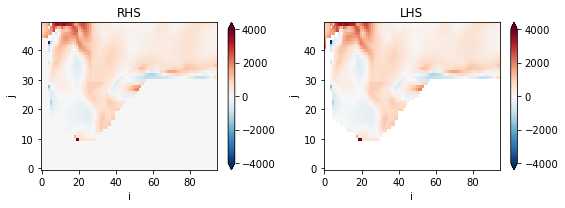

In [13]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(8, 3))
total_tendency_check[1, 0].plot(ax=ax0, robust=True, vmax=4e3)
ax0.set_title('RHS')

(ds.total_tendency_TH_truth + ds.total_tendency_SLT_truth)[1, 0].plot(ax=ax1, robust=True, vmax=4e3)
ax1.set_title('LHS')
plt.tight_layout();

# <font color='Green'>\begin{equation*} \sigma_2\ term \end{equation*} </font>

In [ ]:
sigma2 = xr.apply_ufunc(jmd95numba.rho, ds_tns.SALT, ds_tns.THETA, pref,
                            output_dtypes=[ds_tns.SALT.dtype],
                            dask='parallelized').reset_coords(drop=True).load()

In [ ]:
sigma2_snp = xr.apply_ufunc(jmd95numba.rho, ds_tns.SALT_snp, ds_tns.THETA_snp, pref,
                            output_dtypes=[ds_tns.SALT_snp.dtype],
                            dask='parallelized').reset_coords(drop=True).load()

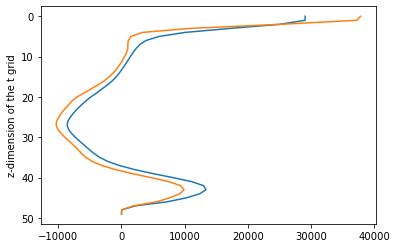

In [35]:
delta_sigma = sigma2_snp.isel(time_snp=-1) - sigma2_snp.isel(time_snp=0)
total_time = (sigma2_snp.time_snp[-1] - sigma2_snp.time_snp[0]).astype('f8')*1e-9

vol = (coords.drF * coords.rA * coords.hFacC)
((delta_sigma * vol).sum(dim=['j', 'i'])/ total_time).plot(y='k', yincrease=False)
(ds.total_tendency_SLT_truth + ds.total_tendency_TH_truth).sum(dim=['j', 'i']).mean(dim='time').plot(y='k', yincrease=False)

# <font color='Green'>\begin{equation*} \frac{\partial V}{\partial t} == \Omega_{tottend-\sigma-truth} + R1 \end{equation*} </font>

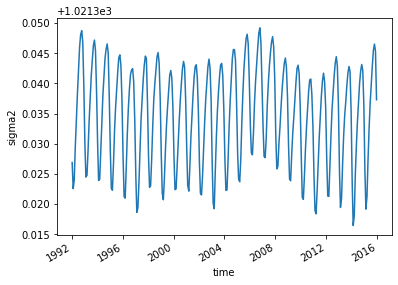

In [36]:
sigma2.mean(dim=['i', 'j', 'k']).plot()

In [42]:
# define bins
delta_sigma = 0.001
sigma_bins = np.arange(1027.5, 1037.5, delta_sigma)

In [43]:
sigma_bins.size

10000

In [39]:
vol = vol.chunk({'i':-1, 'j':-1, 'k':-1})
sigma2 = sigma2.chunk({'i':-1, 'j':-1, 'k':-1, 'time':1})
sigma2_snp = sigma2_snp.chunk({'i':-1, 'j':-1, 'k':-1, 'time_snp':1})
ds = ds.chunk({'i':-1, 'j':-1, 'k':-1, 'i_g':-1, 'j_g':-1, 'k_l':-1, 'time':1})
ds_sig_salt = ds_sig_salt.chunk({'i':-1, 'j':-1, 'k':-1, 'time':1})
ds_sig_theta = ds_sig_theta.chunk({'i':-1, 'j':-1, 'k':-1, 'time':1})

In [40]:
sigma_dist = histogram(sigma2_snp.rename('sigma2'), bins=[sigma_bins],
                       weights=vol, dim=['i', 'j', 'k']).load()

(1036.8, 1037.4)

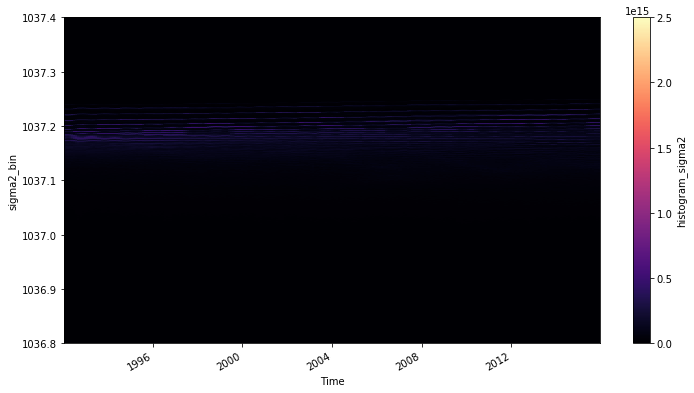

In [24]:
sigma_dist.plot(x='time_snp', figsize=(12, 6), vmax=2.5e15, cmap='magma')
plt.ylim(1036.8, 1037.4)

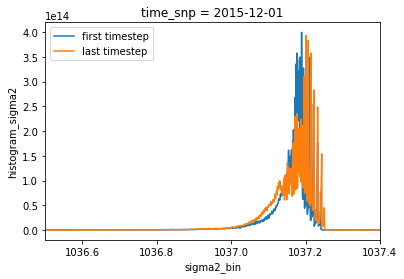

In [25]:
sigma_dist[0].plot(label='first timestep')
sigma_dist[-1].plot(label='last timestep')
plt.legend()
plt.xlim(1036.5, 1037.4);

(1037.5, 1036.4)

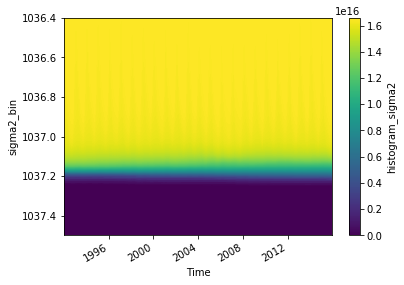

In [26]:
# cumulative volume
V = sigma_dist.isel(sigma2_bin=slice(None, None, -1)).cumsum(dim='sigma2_bin')
V.transpose().plot()
plt.ylim(1037.5, 1036.4)

In [27]:
V

<xarray.DataArray 'histogram_sigma2' (time_snp: 287, sigma2_bin: 9999)>
array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.65796766e+16, 1.65796766e+16, 1.65796766e+16],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.65796766e+16, 1.65796766e+16, 1.65796766e+16],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.65796766e+16, 1.65796766e+16, 1.65796766e+16],
       ...,
       [0.00000000e+00, 0.00000000e+00, 2.13153915e+10, ...,
        1.65796979e+16, 1.65796979e+16, 1.65796979e+16],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.65796766e+16, 1.65796766e+16, 1.65796766e+16],
       [2.13153915e+10, 2.13153915e+10, 2.13153915e+10, ...,
        1.65796979e+16, 1.65796979e+16, 1.65796979e+16]])
Coordinates:
  * time_snp    (time_snp) datetime64[ns] 1992-02-01 1992-03-01 ... 2015-12-01
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.028e+03 1.028e+03

(1037.5, 1036.5)

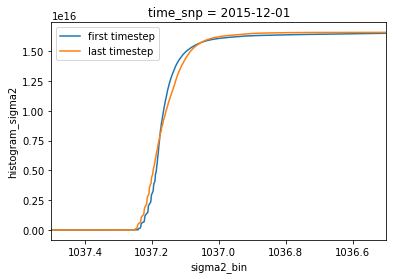

In [28]:
V[0].plot(label='first timestep')
V[-1].plot(label='last timestep')
plt.legend()
plt.xlim(1037.5, 1036.5)

In [29]:
delta_V = V.diff(dim='time_snp')
delta_V.coords['time'] = 'time_snp', ds_tns.time[1:-1].values

In [30]:
delta_V

<xarray.DataArray 'histogram_sigma2' (time_snp: 286, sigma2_bin: 9999)>
array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.69848218e+10, -1.69848218e+10, -1.69848218e+10],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  2.13153915e+10, ...,
        -2.07057613e+10, -2.07057613e+10, -2.07057613e+10],
       [ 0.00000000e+00,  0.00000000e+00, -2.13153915e+10, ...,
        -2.13153915e+10, -2.13153915e+10, -2.13153915e+10],
       [ 2.13153915e+10,  2.13153915e+10,  2.13153915e+10, ...,
         2.13153915e+10,  2.13153915e+10,  2.13153915e+10]])
Coordinates:
  * time_snp    (time_snp) datetime64[ns] 1992-03-01 1992-04-01 ... 2015-12-01
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.028e+03 1.028e+03
    time        (time_snp) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14

## $\frac{\partial \mathcal{V}}{\partial t}$

In [31]:
dVdt = delta_V.swap_dims({'time_snp': 'time'}) / ds_tns.dt[1:-1]

In [32]:
dVdt

<xarray.DataArray (time: 286, sigma2_bin: 9999)>
dask.array<true_divide, shape=(286, 9999), dtype=float64, chunksize=(286, 9999), chunktype=numpy.ndarray>
Coordinates:
    time_snp    (time) datetime64[ns] 1992-03-01 1992-04-01 ... 2015-12-01
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.028e+03 1.028e+03
  * time        (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14

(1036, 1037.5)

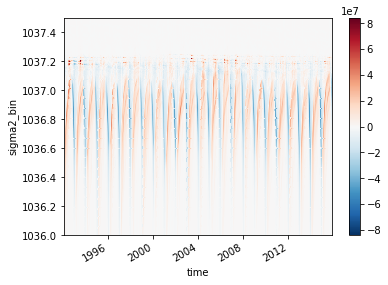

In [33]:
dVdt.plot(x='time')
plt.ylim(1036, 1037.5)

## $\Omega_{total}$

In [34]:
omega_total_th = - histogram(sigma2.rename('sigma2'), bins=[sigma_bins],
                          weights=ds.total_tendency_TH_truth.fillna(0.),
                          dim=['i', 'j', 'k']) / (- delta_sigma)
omega_total_th.load()

omega_total_slt = - histogram(sigma2.rename('sigma2'), bins=[sigma_bins],
                          weights=ds.total_tendency_SLT_truth.fillna(0.),
                          dim=['i', 'j', 'k']) / (-delta_sigma)
omega_total_slt.load()

omega_total = omega_total_th + omega_total_slt
omega_total.load()

<xarray.DataArray 'histogram_sigma2' (time: 288, sigma2_bin: 9999)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * time        (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * sigma2_bin  (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03 1.037e+03

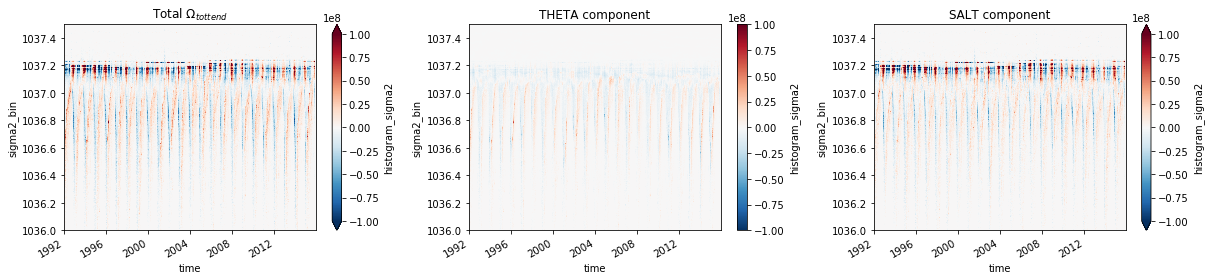

In [35]:
fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(17,4))

omega_total.plot(x='time', vmax=1e8, ax=ax0)
ax0.set_ylim(ymin=1036)
ax0.set_title(r'Total $\Omega_{tottend}$')

omega_total_th.plot(x='time', vmax=1e8, ax=ax1)
ax1.set_ylim(ymin=1036)
ax1.set_title('THETA component')

omega_total_slt.plot(x='time', vmax=1e8, ax=ax2)
ax2.set_ylim(ymin=1036)
ax2.set_title('SALT component')

plt.tight_layout();

## <font color='Green'>\begin{equation*} R1 = \frac{\partial \mathcal{V}}{\partial t} - \Omega_{total} \end{equation*} (Discretization of salt layers) </font>

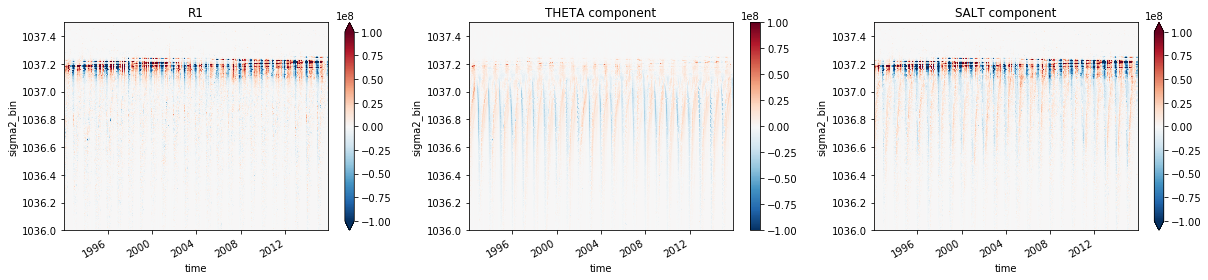

In [36]:
R1 = dVdt - omega_total[1:-1]
R1_th = dVdt - omega_total_th[1:-1]
R1_slt = dVdt - omega_total_slt[1:-1]

fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(17,4))

R1.plot(x='time', vmax=1e8, ax=ax0)
ax0.set_ylim(ymin=1036)
ax0.set_title('R1')

R1_th.plot(x='time', vmax=1e8, ax=ax1)
ax1.set_ylim(ymin=1036)
ax1.set_title('THETA component')

R1_slt.plot(x='time', vmax=1e8, ax=ax2)
ax2.set_ylim(ymin=1036)
ax2.set_title('SALT component')

plt.tight_layout();

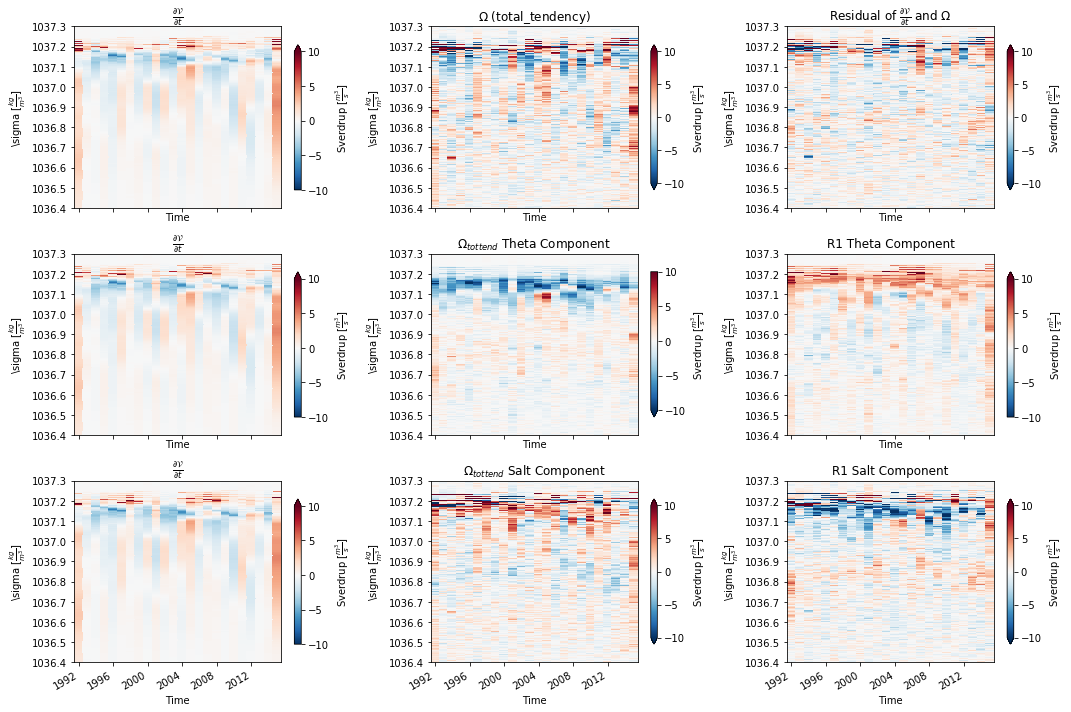

In [37]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10), sharex=True)

(dVdt/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[0,0], vmax=10,
                                                     cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[0,0].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')#, fontsize=14)
axes[0,0].set_xlabel('Time')#, fontsize=14)
axes[0,0].set_title(r'$\frac{\partial \mathcal{V}}{\partial t}$')#, fontsize=24)
axes[0,0].set_ylim(1036.4, 1037.3)

(omega_total[1:-1]/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[0,1], vmax=10,
                                                            cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[0,1].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[0,1].set_xlabel('Time')#, fontsize=14)
axes[0,1].set_title('$\Omega$ (total_tendency)')
axes[0,1].set_ylim(1036.4, 1037.3)

(R1/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[0,2], vmax=10,
                                                   cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[0,2].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[0,2].set_xlabel('Time')
axes[0,2].set_title(r'Residual of $\frac{\partial \mathcal{V}}{\partial t}$ and $\Omega$')
axes[0,2].set_ylim(1036.4, 1037.3)

(dVdt/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[1,0], vmax=10,
                                                     cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[1,0].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[1,0].set_xlabel('Time')
axes[1,0].set_title(r'$\frac{\partial \mathcal{V}}{\partial t}$')
axes[1,0].set_ylim(1036.4, 1037.3)

(omega_total_th[1:-1]/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[1,1], vmax=10,
                                                            cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[1,1].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[1,1].set_xlabel('Time')
axes[1,1].set_title(r'$\Omega_{tottend}$ Theta Component')
axes[1,1].set_ylim(1036.4, 1037.3)

(R1_th/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[1,2], vmax=10,
                                                   cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[1,2].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[1,2].set_xlabel('Time')#, fontsize=14)
axes[1,2].set_title(r'R1 Theta Component')
axes[1,2].set_ylim(1036.4, 1037.3)

(dVdt/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[2,0], vmax=10,
                                                     cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[2,0].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[2,0].set_xlabel('Time')
axes[2,0].set_title(r'$\frac{\partial \mathcal{V}}{\partial t}$')
axes[2,0].set_ylim(1036.4, 1037.3)

(omega_total_slt[1:-1]/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[2,1], vmax=10,
                                                            cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[2,1].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[2,1].set_xlabel('Time')
axes[2,1].set_title(r'$\Omega_{tottend}$ Salt Component')
axes[2,1].set_ylim(1036.4, 1037.3)

(R1_slt/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[2,2], vmax=10,
                                                   cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[2,2].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[2,2].set_xlabel('Time')#, fontsize=14)
axes[2,2].set_title(r'R1 Salt Component')
axes[2,2].set_ylim(1036.4, 1037.3)

plt.tight_layout();

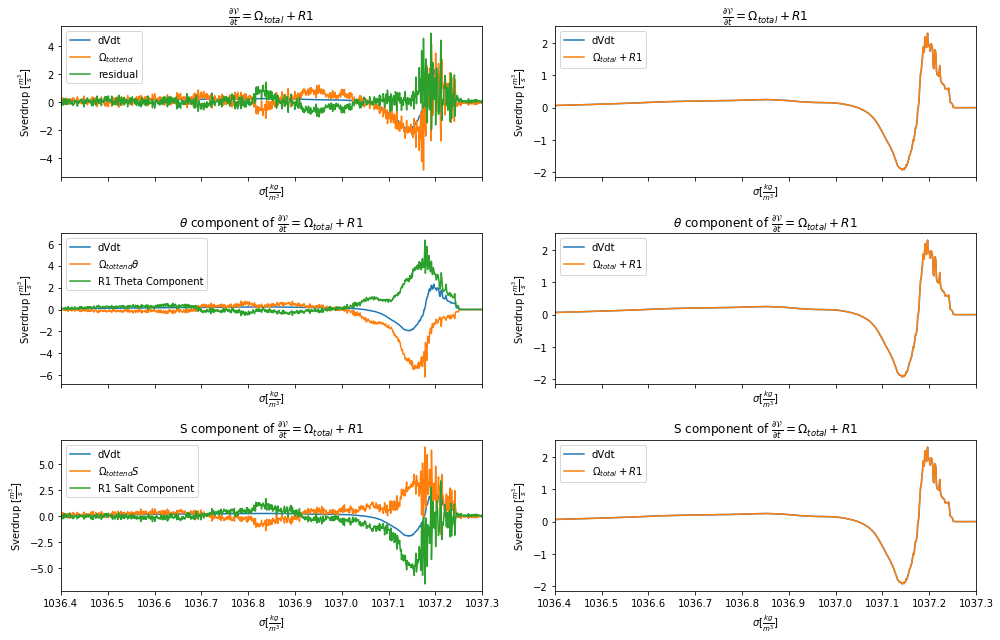

In [38]:
fig, axes = plt.subplots(3, 2, figsize=(14, 9), sharex=True)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=axes[0,0])
(omega_total/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend}$', ax=axes[0,0])
(R1/1e6).mean(dim='time').plot(label='residual', ax=axes[0,0])
axes[0,0].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[0,0].set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[0,0].legend()
axes[0,0].set_title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Omega_{total} + R1$')
axes[0,0].set_xlim(1036.4, 1037.3)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=axes[0,1])
((omega_total + R1)/1e6).mean(dim='time').plot(label=r'$\Omega_{total} + R1$', ax=axes[0,1])
axes[0,1].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[0,1].set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[0,1].legend()
axes[0,1].set_title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Omega_{total} + R1$')
axes[0,1].set_xlim(1036.4, 1037.3)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=axes[1,0])
(omega_total_th/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend} \theta$', ax=axes[1,0])
(R1_th/1e6).mean(dim='time').plot(label='R1 Theta Component', ax=axes[1,0])
axes[1,0].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[1,0].set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[1,0].legend()
axes[1,0].set_title(r'$\theta$ component of $\frac{\partial \mathcal{V}}{\partial t} = \Omega_{total} + R1$ ')
axes[1,0].set_xlim(1036.4, 1037.3)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=axes[1,1])
((omega_total_th + R1_th)/1e6).mean(dim='time').plot(label=r'$\Omega_{total} + R1$', ax=axes[1,1])
axes[1,1].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[1,1].set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[1,1].legend()
axes[1,1].set_title(r'$\theta$ component of $\frac{\partial \mathcal{V}}{\partial t} = \Omega_{total} + R1$')
axes[1,1].set_xlim(1036.4, 1037.3)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=axes[2,0])
(omega_total_slt/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend} S$', ax=axes[2,0])
(R1_slt/1e6).mean(dim='time').plot(label='R1 Salt Component', ax=axes[2,0])
axes[2,0].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[2,0].set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[2,0].legend()
axes[2,0].set_title(r'S component of $\frac{\partial \mathcal{V}}{\partial t} = \Omega_{total} + R1$')
axes[2,0].set_xlim(1036.4, 1037.3)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=axes[2,1])
((omega_total_slt + R1_slt)/1e6).mean(dim='time').plot(label=r'$\Omega_{total} + R1$', ax=axes[2,1])
axes[2,1].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[2,1].set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[2,1].legend()
axes[2,1].set_title(r'S component of $\frac{\partial \mathcal{V}}{\partial t} = \Omega_{total} + R1$')
axes[2,1].set_xlim(1036.4, 1037.3)

plt.tight_layout();

## <span style='color:Green'> \begin{equation*} \Omega_{transformation-rate} \end{equation*}

In [39]:
def histogram_func(variable):
    """Generalized xhistogram's histogram function 
    for adv and diff flux terms"""
    hist = histogram(sigma2.rename('sigma2'), bins=[sigma_bins],
                     weights=variable.fillna(0.), dim=['i', 'j', 'k'])
    return hist / (-delta_sigma)

In [40]:
all_tendencies_th = list(ds_sig_theta)
all_tendencies_slt = list(ds_sig_salt)

In [41]:
all_dsets_th = xr.merge([histogram_func(ds_sig_theta[var]).rename('OMEGA_' + var)
                      for var in all_tendencies_th])
all_dsets_slt = xr.merge([histogram_func(ds_sig_salt[var]).rename('OMEGA_' + var)
                      for var in all_tendencies_slt])

In [42]:
all_dsets = xr.merge([all_dsets_th, all_dsets_slt])

In [43]:
omega_trans_rate_th = - (all_dsets_th.OMEGA_conv_horiz_diff_flux_TH + 
                         all_dsets_th.OMEGA_conv_vert_diff_flux_TH +
                         all_dsets_th.OMEGA_sw_flux_conv_TH + 
                         all_dsets_th.OMEGA_surface_flux_conv_TH)
omega_trans_rate_th.load()

omega_trans_rate_slt = - (all_dsets_slt.OMEGA_conv_horiz_diff_flux_SLT + 
                         all_dsets_slt.OMEGA_conv_vert_diff_flux_SLT +
                         all_dsets_slt.OMEGA_salt_plume + 
                         all_dsets_slt.OMEGA_surface_flux_SLT)
omega_trans_rate_slt.load()

omega_trans_rate = omega_trans_rate_th + omega_trans_rate_slt
omega_trans_rate.load()

<xarray.DataArray (time: 288, sigma2_bin: 9999)>
array([[    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       ...,
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        , -4873.4525403 , -5749.59123398]])
Coordinates:
  * time        (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * sigma2_bin  (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03 1.037e+03

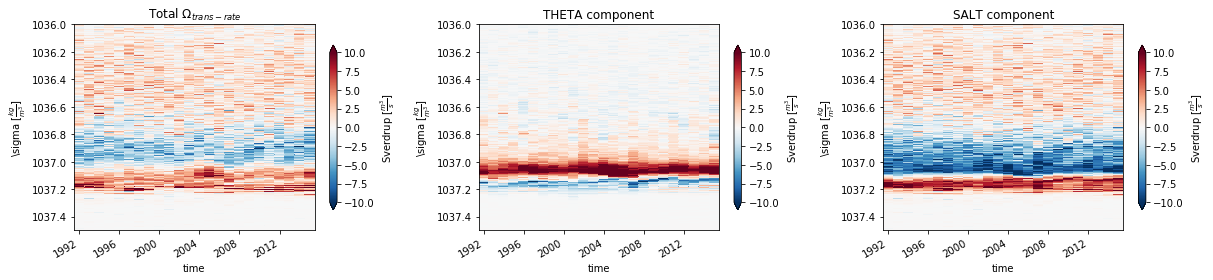

In [44]:
fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(17,4))

(omega_trans_rate.resample(time='AS').mean()/1e6).plot(x='time', ax=ax0, vmax=10,
                                                       cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax0.set_ylim(1037.5, 1036)
ax0.set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
ax0.set_title(r'Total $\Omega_{trans-rate}$')

(omega_trans_rate_th.resample(time='AS').mean()/1e6).plot(x='time', ax=ax1, vmax=10,
                                                          cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax1.set_ylim(1037.5, 1036)
ax1.set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
ax1.set_title('THETA component')

(omega_trans_rate_slt.resample(time='AS').mean()/1e6).plot(x='time', ax=ax2, vmax=10,
                                                           cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax2.set_ylim(1037.5, 1036)
ax2.set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
ax2.set_title('SALT component')

plt.tight_layout();

## <font color='Green'> \begin{equation*} \Psi_{adv} = \Psi_{vel} + R2 \end{equation*} (Numerical Mixing) </font>

## $\Psi_{adv}$

In [45]:
psi_adv_th = -(all_dsets_th.OMEGA_conv_horiz_adv_flux_TH + all_dsets_th.OMEGA_conv_vert_adv_flux_TH)
psi_adv_th.load()
psi_adv_slt = -(all_dsets_slt.OMEGA_conv_horiz_adv_flux_SLT + all_dsets_slt.OMEGA_conv_vert_adv_flux_SLT)
psi_adv_slt.load()
psi_adv = psi_adv_th + psi_adv_slt
psi_adv.load()

<xarray.DataArray (time: 288, sigma2_bin: 9999)>
array([[      0.        ,       0.        ,       0.        , ...,
              0.        ,       0.        ,       0.        ],
       [      0.        ,       0.        ,       0.        , ...,
              0.        ,       0.        ,       0.        ],
       [      0.        ,       0.        ,       0.        , ...,
              0.        ,       0.        ,       0.        ],
       ...,
       [      0.        ,       0.        ,       0.        , ...,
              0.        ,       0.        ,       0.        ],
       [      0.        ,       0.        ,       0.        , ...,
              0.        ,       0.        ,       0.        ],
       [      0.        ,       0.        ,       0.        , ...,
              0.        , -179030.63259718, -186602.20591668]])
Coordinates:
  * time        (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * sigma2_bin  (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03 1.037e+03

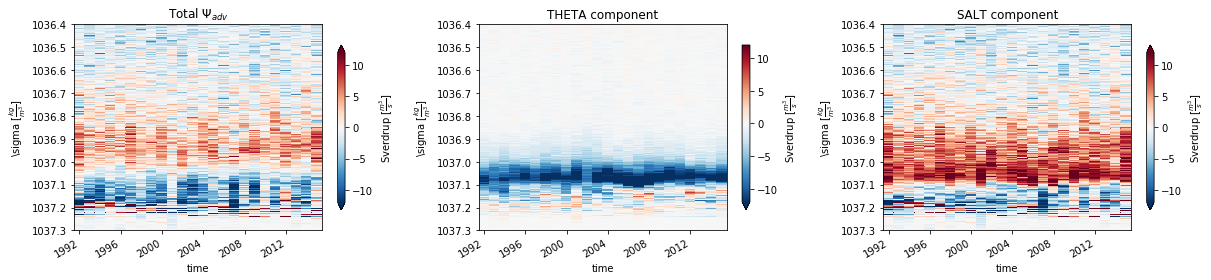

In [46]:
fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(17,4))

(psi_adv.resample(time='AS').mean()/1e6).plot(x='time', ax=ax0, vmax=12,
                                                       cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax0.set_ylim(1037.3, 1036.4)
ax0.set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
ax0.set_title(r'Total $\Psi_{adv}$')

(psi_adv_th.resample(time='AS').mean()/1e6).plot(x='time', ax=ax1, vmax=12,
                                                          cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax1.set_ylim(1037.3, 1036.4)
ax1.set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
ax1.set_title('THETA component')

(psi_adv_slt.resample(time='AS').mean()/1e6).plot(x='time', ax=ax2, vmax=12,
                                                           cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax2.set_ylim(1037.3, 1036.4)
ax2.set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
ax2.set_title('SALT component')

plt.tight_layout();

## $\Psi_{vel}$

In [47]:
ds.UVELSTAR

<xarray.DataArray 'UVELSTAR' (time: 288, k: 50, j: 50, i_g: 96)>
dask.array<rechunk-merge, shape=(288, 50, 50, 96), dtype=float32, chunksize=(1, 50, 50, 96), chunktype=numpy.ndarray>
Coordinates:
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
Dimensions without coordinates: j, i_g
Attributes:
    coordinates:    hFacW dt PHrefC Z iter dxC drF rAw dyG
    long_name:      Zonal Component of Bolus Velocity
    mate:           VVELSTAR
    standard_name:  UVELSTAR
    units:          m/s

In [48]:
ds.UVEL

<xarray.DataArray 'UVEL' (time: 288, k: 50, j: 50, i_g: 96)>
dask.array<rechunk-merge, shape=(288, 50, 50, 96), dtype=float32, chunksize=(1, 50, 50, 96), chunktype=numpy.ndarray>
Coordinates:
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
Dimensions without coordinates: j, i_g
Attributes:
    long_name:      Zonal Mass-Weighted Comp of Velocity (m/s)
    mate:           VVELMASS
    standard_name:  UVELMASS
    units:          m/s

In [49]:
#this is the "dA" part of the equation
u_transport_right = (ds.UVEL * coords.dyG * coords.drF).isel(i_g=-1) #m^3/s #(-) values -> westward, (+) values -> east
u_transport_left = (ds.UVEL * coords.dyG * coords.drF).isel(i_g=0)
u_bolus_transport_right = (ds.UVELSTAR * coords.dyG * coords.drF).isel(i_g=-1)
u_bolus_transport_left = (ds.UVELSTAR * coords.dyG * coords.drF).isel(i_g=0)
v_transport = (ds.VVEL * coords.dxG * coords.drF).isel(j_g=-1) #m^3/s #(-) values -> south, (+) values -> north
v_bolus_transport = (ds.VVELSTAR * coords.dxG * coords.drF).isel(j_g=-1)
w_transport = ds.WVEL.isel(k_l=0) * coords.rA #m^3/s #(-) values are massflux into the ocean, (+) values are massflux out of the ocean

In [50]:
u_transport_mean_value = (u_transport_right.sum(dim=['j', 'k']) +
                          u_bolus_transport_right.sum(dim=['j', 'k']) -
                          u_transport_left.sum(dim=['j', 'k']) -
                          u_bolus_transport_left.sum(dim=['j', 'k'])).mean(dim='time')/1e6
u_transport_mean_value.load()

<xarray.DataArray ()>
array(-38.406273, dtype=float32)

In [51]:
v_transport_mean_value = (v_transport + v_bolus_transport).mean(dim='time').sum()/1e6
v_transport_mean_value.load()

<xarray.DataArray ()>
array(38.4216, dtype=float32)

In [52]:
w_transport_mean_value = w_transport.mean(dim='time').sum()/1e6
w_transport_mean_value.load()

<xarray.DataArray ()>
array(-0.01507538, dtype=float32)
Coordinates:
    k_l      int64 0

In [53]:
residual = u_transport_mean_value + v_transport_mean_value + w_transport_mean_value
residual

<xarray.DataArray ()>
array(0.00025208, dtype=float32)
Coordinates:
    k_l      int64 0

In [54]:
# hack theta to be on same grid pt as velocity components
sigma_at_u_right = sigma2.isel(i=-1)
sigma_at_u_left = sigma2.isel(i=0)
sigma_at_v = sigma2.isel(j=-1)
sigma_at_w = sigma2.isel(k=0)

In [55]:
#this is the delta function part of the equation above
u_binned_right = histogram(sigma_at_u_right.rename('sigma2'), bins=[sigma_bins],
                           weights=u_transport_right, dim=['k', 'j']) 
u_binned_left = histogram(sigma_at_u_left.rename('sigma2'), bins=[sigma_bins],
                          weights=u_transport_left, dim=['k', 'j'])
v_binned = histogram(sigma_at_v.rename('sigma2'), bins=[sigma_bins],
                     weights=v_transport.chunk({'i':-1}), dim=['k', 'i'])
u_bolus_binned_right = histogram(sigma_at_u_right.rename('sigma2'), bins=[sigma_bins],
                           weights=u_bolus_transport_right, dim=['k', 'j']) 
u_bolus_binned_left = histogram(sigma_at_u_left.rename('sigma2'), bins=[sigma_bins],
                          weights=u_bolus_transport_left, dim=['k', 'j'])
v_bolus_binned = histogram(sigma_at_v.rename('sigma2'), bins=[sigma_bins],
                     weights=v_bolus_transport.chunk({'i':-1}), dim=['k', 'i'])
w_binned = histogram(sigma_at_w.rename('sigma2'), bins=[sigma_bins],
                     weights=w_transport.chunk({'i':-1}), dim=['i', 'j'])

In [56]:
#`isel` is letting cumsum act in reverse order (from densenst to lightest)
psi_vel = - (u_binned_right + u_bolus_binned_right - 
             u_binned_left - u_bolus_binned_left + 
             v_binned + v_bolus_binned).isel(sigma2_bin=slice(None, None, -1)).cumsum(dim='sigma2_bin')
psi_vel.load()

<xarray.DataArray 'histogram_sigma2' (time: 288, sigma2_bin: 9999)>
array([[    -0.        ,     -0.        ,     -0.        , ...,
        -61548.32072804, -61548.32072804, -61548.32072804],
       [    -0.        ,     -0.        ,     -0.        , ...,
        -54672.66795915, -54672.66795915, -54672.66795915],
       [    -0.        ,     -0.        ,     -0.        , ...,
        -56382.30092742, -56382.30092742, -56382.30092742],
       ...,
       [    -0.        ,     -0.        ,     -0.        , ...,
         13240.14867699,  13240.14867699,  13240.14867699],
       [    -0.        ,     -0.        ,     -0.        , ...,
          1205.4945927 ,   1205.4945927 ,   1205.4945927 ],
       [    -0.        ,     -0.        ,     -0.        , ...,
        -23472.61972128, -23472.61972128, -23472.61972128]])
Coordinates:
  * time        (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.028e+03 1.028e+03

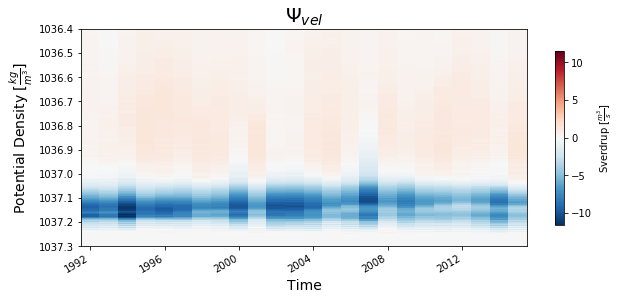

In [57]:
(psi_vel/1e6).resample(time='AS').mean(dim='time').plot(x='time', figsize=(10,4),
                                                        cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
plt.ylabel(r'Potential Density $[\frac{kg}{m^3}]$', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.title('$\Psi_{vel}$', fontsize=20)
plt.ylim(1037.3, 1036.4);

In [58]:
#`isel` is letting cumsum act in reverse order (from densenst to lightest)
psi_vel_no_bolus = - (u_binned_right - u_binned_left + v_binned).isel(sigma2_bin=slice(None, None, -1)).cumsum(dim='sigma2_bin')
psi_vel_no_bolus.load()

<xarray.DataArray 'histogram_sigma2' (time: 288, sigma2_bin: 9999)>
array([[    -0.        ,     -0.        ,     -0.        , ...,
        -61548.33563185, -61548.33563185, -61548.33563185],
       [    -0.        ,     -0.        ,     -0.        , ...,
        -54672.67465729, -54672.67465729, -54672.67465729],
       [    -0.        ,     -0.        ,     -0.        , ...,
        -56382.32209933, -56382.32209933, -56382.32209933],
       ...,
       [    -0.        ,     -0.        ,     -0.        , ...,
         13240.12101018,  13240.12101018,  13240.12101018],
       [    -0.        ,     -0.        ,     -0.        , ...,
          1205.4426012 ,   1205.4426012 ,   1205.4426012 ],
       [    -0.        ,     -0.        ,     -0.        , ...,
        -23472.65705764, -23472.65705764, -23472.65705764]])
Coordinates:
  * time        (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.028e+03 1.028e+03

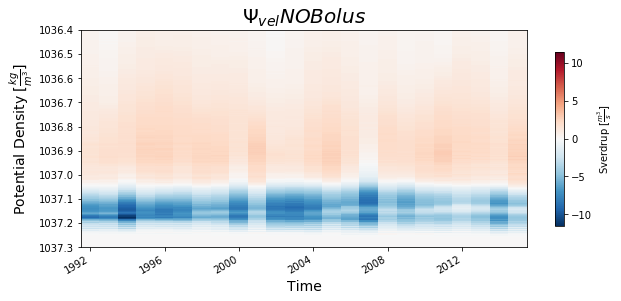

In [59]:
(psi_vel_no_bolus/1e6).resample(time='AS').mean(dim='time').plot(x='time', figsize=(10,4),
                                                        cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
plt.ylabel(r'Potential Density $[\frac{kg}{m^3}]$', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.title('$\Psi_{vel} NO Bolus$', fontsize=20)
plt.ylim(1037.3, 1036.4);

(1035, 1038)

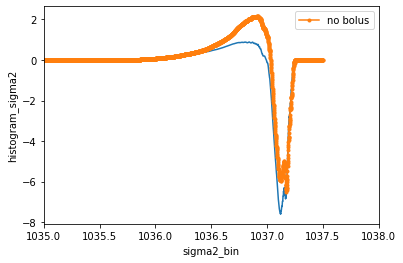

In [60]:
(psi_vel/1e6).mean(dim='time').plot()
(psi_vel_no_bolus/1e6).mean(dim='time').plot(label='no bolus', marker='.')
plt.legend()
plt.xlim(1035, 1038)

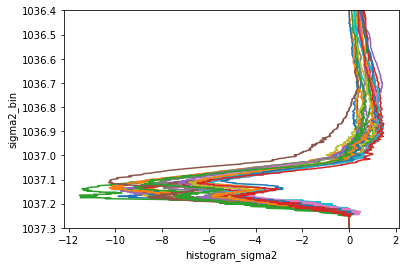

In [61]:
(psi_vel/1e6).resample(time='AS').mean(dim='time').plot.line(y='sigma2_bin', add_legend=False)
plt.ylim(1037.3, 1036.4);

## R2 = $\Psi_{adv} - \Psi_{vel}$ (Numerical Mixing)

In [62]:
R2 = (psi_adv - psi_vel).load()
R2_th = (psi_adv_th - psi_vel).load()
R2_slt = (psi_adv_slt - psi_vel).load()

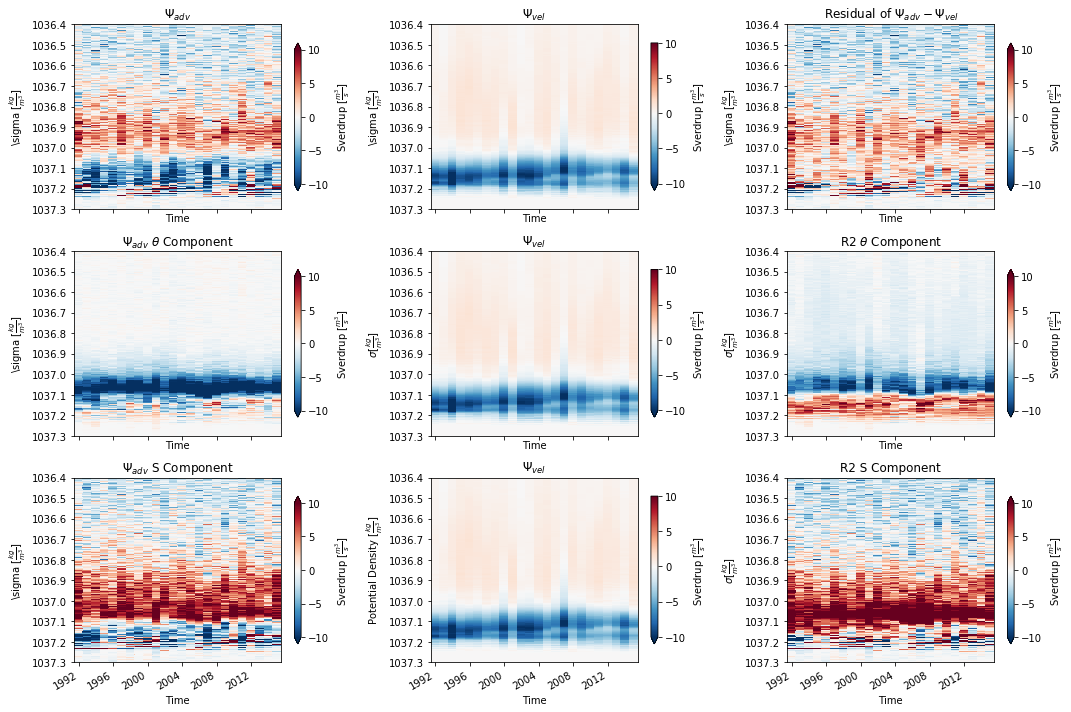

In [63]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10), sharex=True)

(psi_adv/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[0,0], vmax=10,
                                                        cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[0,0].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[0,0].set_xlabel('Time')
axes[0,0].set_title(r'$\Psi_{adv}$')
axes[0,0].set_ylim(1037.3, 1036.4)

(psi_vel/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[0,1], vmax=10, 
                                                        cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[0,1].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[0,1].set_xlabel('Time')
axes[0,1].set_title('$\Psi_{vel}$')
axes[0,1].set_ylim(1037.3, 1036.4)

(R2/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[0,2], vmax=10, 
                                                   cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[0,2].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[0,2].set_xlabel('Time')
axes[0,2].set_title(r'Residual of $\Psi_{adv} - \Psi_{vel}$')
axes[0,2].set_ylim(1037.3, 1036.4)

(psi_adv_th/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[1,0], vmax=10,
                                                        cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[1,0].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[1,0].set_xlabel('Time')
axes[1,0].set_title(r'$\Psi_{adv}$ $\theta$ Component')
axes[1,0].set_ylim(1037.3, 1036.4)

(psi_vel/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[1,1], vmax=10, 
                                                        cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[1,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[1,1].set_xlabel('Time')
axes[1,1].set_title('$\Psi_{vel}$')
axes[1,1].set_ylim(1037.3, 1036.4)

(R2_th/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[1,2], vmax=10, 
                                                   cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[1,2].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[1,2].set_xlabel('Time')
axes[1,2].set_title(r'R2 $\theta$ Component')
axes[1,2].set_ylim(1037.3, 1036.4)

(psi_adv_slt/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[2,0], vmax=10,
                                                        cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[2,0].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[2,0].set_xlabel('Time')
axes[2,0].set_title(r'$\Psi_{adv}$ S Component')
axes[2,0].set_ylim(1037.3, 1036.4)

(psi_vel/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[2,1], vmax=10, 
                                                        cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[2,1].set_ylabel(r'Potential Density $[\frac{kg}{m^3}]$')
axes[2,1].set_xlabel('Time')
axes[2,1].set_title('$\Psi_{vel}$')
axes[2,1].set_ylim(1037.3, 1036.4)

(R2_slt/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[2,2], vmax=10, 
                                                   cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[2,2].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[2,2].set_xlabel('Time')
axes[2,2].set_title(r'R2 S Component')
axes[2,2].set_ylim(1037.3, 1036.4)

plt.tight_layout();

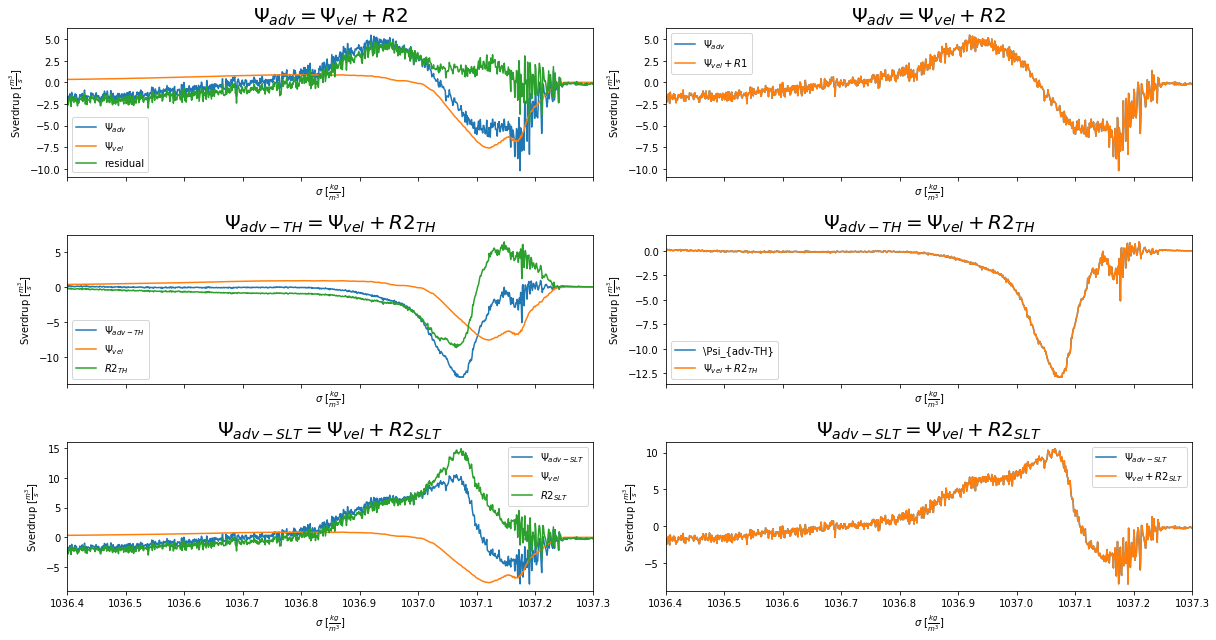

In [64]:
fig, axes = plt.subplots(3, 2, figsize=(17, 9), sharex=True)

(psi_adv/1e6).mean(dim='time').plot(label=r'$\Psi_{adv}$', ax=axes[0,0])
(psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi_{vel}$', ax=axes[0,0])
(R2/1e6).mean(dim='time').plot(label='residual', ax=axes[0,0])
axes[0,0].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[0,0].set_xlabel(r'$\sigma\ [\frac{kg}{m^3}]$')
axes[0,0].legend()
axes[0,0].set_title(r'$\Psi_{adv} = \Psi_{vel} + R2$', fontsize=20)
axes[0,0].set_xlim(1036.4, 1037.3)

(psi_adv/1e6).mean(dim='time').plot(label=r'$\Psi_{adv}$', ax=axes[0,1])
((psi_vel + R2)/1e6).mean(dim='time').plot(label=r'$\Psi_{vel} + R1$', ax=axes[0,1])
axes[0,1].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[0,1].set_xlabel(r'$\sigma\ [\frac{kg}{m^3}]$')
axes[0,1].legend()
axes[0,1].set_title(r'$\Psi_{adv} = \Psi_{vel} + R2$', fontsize=20)
axes[0,1].set_xlim(1036.4, 1037.3)

(psi_adv_th/1e6).mean(dim='time').plot(label=r'$\Psi_{adv-TH}$', ax=axes[1,0])
(psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi_{vel}$', ax=axes[1,0])
(R2_th/1e6).mean(dim='time').plot(label=r'$R2_{TH}$', ax=axes[1,0])
axes[1,0].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[1,0].set_xlabel(r'$\sigma\ [\frac{kg}{m^3}]$')
axes[1,0].legend()
axes[1,0].set_title(r'$\Psi_{adv-TH} = \Psi_{vel} + R2_{TH}$ ', fontsize=20)
axes[1,0].set_xlim(1036.4, 1037.3)

(psi_adv_th/1e6).mean(dim='time').plot(label='\Psi_{adv-TH}', ax=axes[1,1])
((psi_vel + R2_th)/1e6).mean(dim='time').plot(label=r'$\Psi_{vel} + R2_{TH}$', ax=axes[1,1])
axes[1,1].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[1,1].set_xlabel(r'$\sigma\ [\frac{kg}{m^3}]$')
axes[1,1].legend()
axes[1,1].set_title(r'$\Psi_{adv-TH} = \Psi_{vel} + R2_{TH}$', fontsize=20)
axes[1,1].set_xlim(1036.4, 1037.3)

(psi_adv_slt/1e6).mean(dim='time').plot(label=r'$\Psi_{adv-SLT}$', ax=axes[2,0])
(psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi_{vel}$', ax=axes[2,0])
(R2_slt/1e6).mean(dim='time').plot(label=r'$R2_{SLT}$', ax=axes[2,0])
axes[2,0].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[2,0].set_xlabel(r'$\sigma\ [\frac{kg}{m^3}]$')
axes[2,0].legend()
axes[2,0].set_title(r'$\Psi_{adv-SLT} = \Psi_{vel} + R2_{SLT}$', fontsize=20)
axes[2,0].set_xlim(1036.4, 1037.3)

(psi_adv_slt/1e6).mean(dim='time').plot(label=r'$\Psi_{adv-SLT}$', ax=axes[2,1])
((psi_vel + R2_slt)/1e6).mean(dim='time').plot(label=r'$\Psi_{vel} + R2_{SLT}$', ax=axes[2,1])
axes[2,1].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[2,1].set_xlabel(r'$\sigma\ [\frac{kg}{m^3}]$')
axes[2,1].legend()
axes[2,1].set_title(r'$\Psi_{adv-SLT} = \Psi_{vel} + R2_{SLT}$', fontsize=20)
axes[2,1].set_xlim(1036.4, 1037.3)

plt.tight_layout();

# <font color='Green'>\begin{equation*} \Omega_{tottend-truth} = \Psi_{adv} + \Omega_{trans-rate} + R3 \end{equation*} </font>

In [65]:
omega_total = omega_total[1:-1]
omega_total_th = omega_total_th[1:-1]
omega_total_slt = omega_total_slt[1:-1]
omega_trans_rate = omega_trans_rate[1:-1]
omega_trans_rate_th = omega_trans_rate_th[1:-1]
omega_trans_rate_slt = omega_trans_rate_slt[1:-1]
psi_adv = psi_adv[1:-1]
psi_adv_th = psi_adv_th[1:-1]
psi_adv_th = psi_adv_th[1:-1]
psi_vel = psi_vel[1:-1]

In [66]:
R3_th = omega_total_th - (psi_adv_th + omega_trans_rate_th)
R3_th.load()
R3_slt = omega_total_slt - (psi_adv_slt + omega_trans_rate_slt)
R3_slt.load()
R3 = omega_total - (psi_adv + omega_trans_rate)
R3.load()

<xarray.DataArray (time: 286, sigma2_bin: 9999)>
array([[    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       ...,
       [    0.        ,     0.        ,     0.        , ...,
        -2985.25791884, -2346.54854796,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ]])
Coordinates:
  * time        (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14
  * sigma2_bin  (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03 1.037e+03

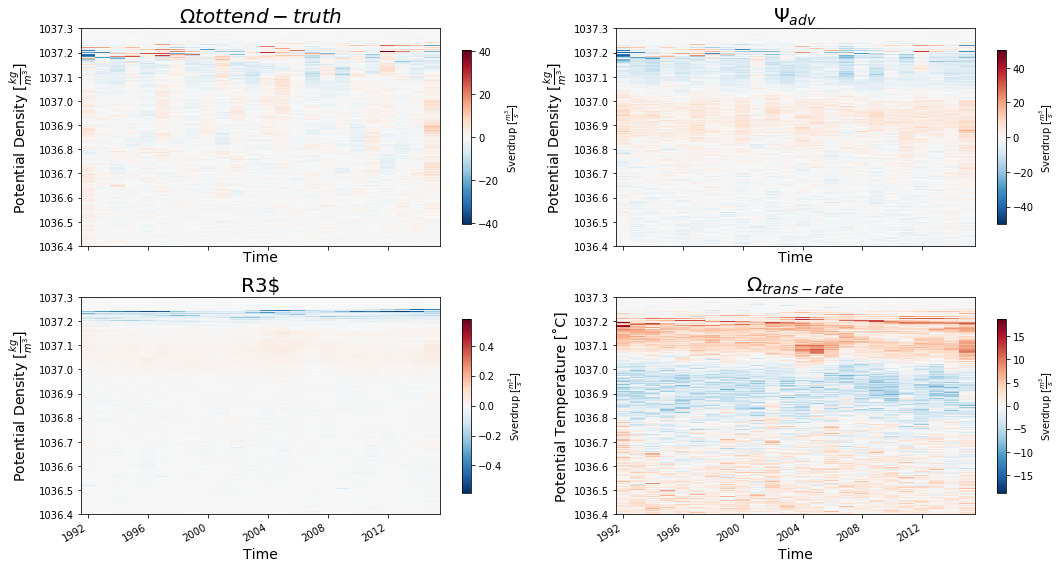

In [67]:
fig, ax = plt.subplots(2, 2, figsize=(15, 8), sharex=True)

(omega_total/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=ax[0,0],
                                                     cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax[0,0].set_ylabel(r'Potential Density $[\frac{kg}{m^3}]$', fontsize=14)
ax[0,0].set_xlabel('Time', fontsize=14)
ax[0,0].set_title(r'$\Omega{tottend-truth}$', fontsize=20)
ax[0,0].set_ylim(1036.4, 1037.3)

(psi_adv/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=ax[0,1], 
                                                            cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax[0,1].set_ylabel(r'Potential Density $[\frac{kg}{m^3}]$', fontsize=14)
ax[0,1].set_xlabel('Time', fontsize=14)
ax[0,1].set_title('$\Psi_{adv}$', fontsize=20)
ax[0,1].set_ylim(1036.4, 1037.3)

(R3/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=ax[1,0], 
                                                   cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax[1,0].set_ylabel(r'Potential Density $[\frac{kg}{m^3}]$', fontsize=14)
ax[1,0].set_xlabel('Time', fontsize=14)
ax[1,0].set_title(r'R3$', fontsize=20)
ax[1,0].set_ylim(1036.4, 1037.3)

(omega_trans_rate/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=ax[1,1], 
                                                            cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax[1,1].set_ylabel('Potential Temperature [˚C]', fontsize=14)
ax[1,1].set_xlabel('Time', fontsize=14)
ax[1,1].set_title('$\Omega_{trans-rate}$', fontsize=20)
ax[1,1].set_ylim(1036.4, 1037.3)

plt.tight_layout();

(1035, 1038)

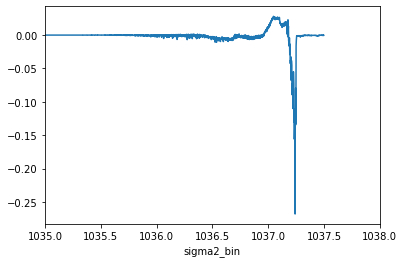

In [68]:
(R3/1e6).mean(dim='time').plot()
plt.xlim(1035, 1038)

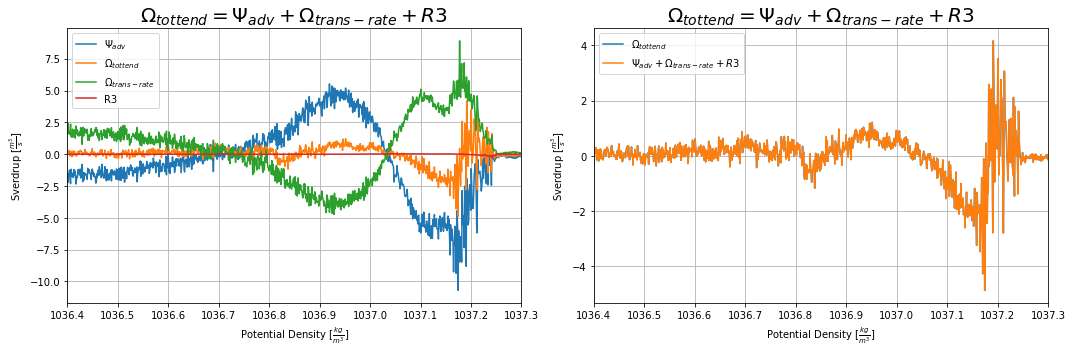

In [69]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 5), sharex=True)

(psi_adv/1e6).mean(dim='time').plot(label=r'$\Psi_{adv}$', ax=ax0)
(omega_total/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend}$', ax=ax0)
(omega_trans_rate/1e6).mean(dim='time').plot(label=r'$\Omega_{trans-rate}$', ax=ax0)
(R3/1e6).mean(dim='time').plot(label='R3', ax=ax0)
ax0.set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
ax0.set_xlabel(r'Potential Density $[\frac{kg}{m^3}]$')
ax0.legend()
ax0.grid()
ax0.set_title(r'$\Omega_{tottend} = \Psi_{adv} + \Omega_{trans-rate} + R3$', fontsize=20)
ax0.set_xlim(1036.4, 1037.3)

(omega_total/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend}$', ax=ax1)
((psi_adv + omega_trans_rate + R3)/1e6).mean(dim='time').plot(label=r'$\Psi_{adv}+\Omega_{trans-rate}+R3$', ax=ax1)
ax1.set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
ax1.set_xlabel(r'Potential Density $[\frac{kg}{m^3}]$')
ax1.legend()
ax1.grid()
ax1.set_title(r'$\Omega_{tottend} = \Psi_{adv} + \Omega_{trans-rate} + R3$', fontsize=20)
ax1.set_xlim(1036.4, 1037.3)

plt.tight_layout();

(1037.5, 1036.5)

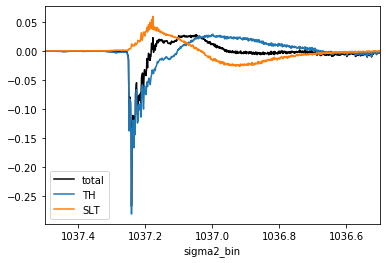

In [70]:
(R3/1e6).mean(dim='time').plot(color='k', label='total')
(R3_th/1e6).mean(dim='time').plot(label='TH')
(R3_slt/1e6).mean(dim='time').plot(label='SLT')
plt.legend()
plt.xlim(1037.5, 1036.5)

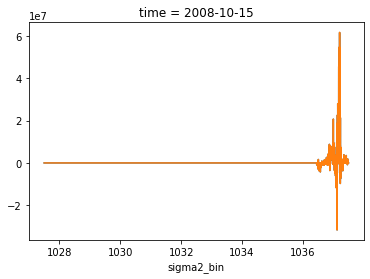

In [71]:
n = 200
omega_total.isel(time=n).plot()
(omega_trans_rate + psi_adv).isel(time=n).plot()

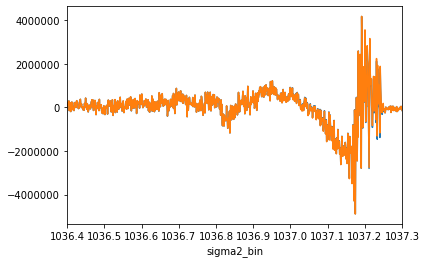

In [72]:
omega_total.mean(dim='time').plot()
(omega_trans_rate + psi_adv).mean(dim='time').plot()
plt.xlim(1036.4, 1037.3);

# <font color='Green'>\begin{equation*} \frac{\partial V}{\partial t} = \Psi_{vel} + R2 + \Omega_{trans-rate} + R3 + R1 \end{equation*} </font>

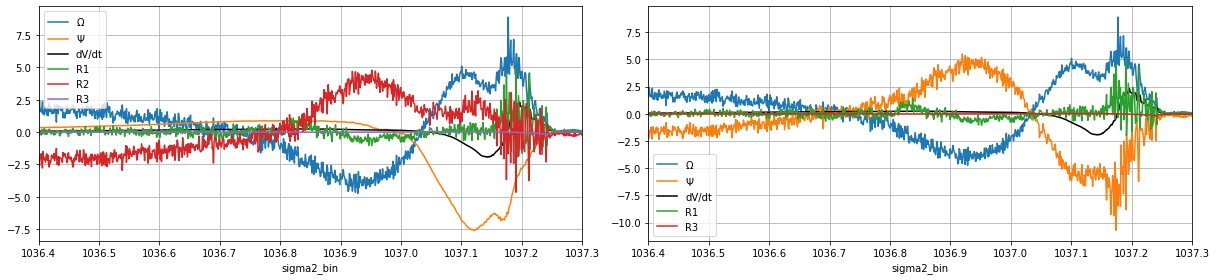

In [73]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(17, 4), sharex=True)

(omega_trans_rate/1e6).mean(dim='time').plot(label=r'$\Omega$', ax=ax0)
(psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi$', ax=ax0)
(dVdt/1e6).mean(dim='time').plot(label='dV/dt', color='k', ax=ax0)
(R1/1e6).mean(dim='time').plot(label='R1', ax=ax0)
(R2/1e6).mean(dim='time').plot(label='R2', ax=ax0)
(R3/1e6).mean(dim='time').plot(label='R3', ax=ax0)
ax0.legend()
ax0.grid()
ax0.set_xlim(1036.4, 1037.3)

(omega_trans_rate/1e6).mean(dim='time').plot(label=r'$\Omega$', ax=ax1)
(psi_adv/1e6).mean(dim='time').plot(label=r'$\Psi$', ax=ax1)
(dVdt/1e6).mean(dim='time').plot(label='dV/dt', color='k', ax=ax1)
(R1/1e6).mean(dim='time').plot(label='R1', ax=ax1)
(R3/1e6).mean(dim='time').plot(label='R3', ax=ax1)
ax1.legend()
ax1.grid()
ax1.set_xlim(1036.4, 1037.3)
plt.tight_layout();

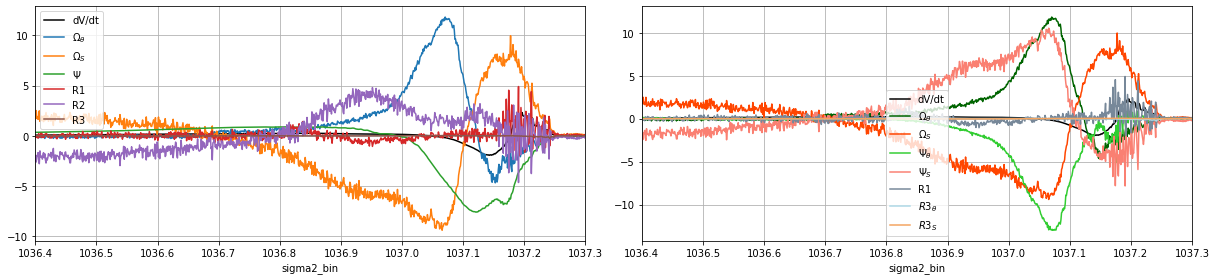

In [74]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(17, 4), sharex=True)

(dVdt/1e6).mean(dim='time').plot(label='dV/dt', color='k', ax=ax0)
(omega_trans_rate_th/1e6).mean(dim='time').plot(label=r'$\Omega_{\theta}$', ax=ax0)
(omega_trans_rate_slt/1e6).mean(dim='time').plot(label=r'$\Omega_S$', ax=ax0)
(psi_vel[1:-1]/1e6).mean(dim='time').plot(label=r'$\Psi$', ax=ax0)

(R1/1e6).mean(dim='time').plot(label='R1', ax=ax0)
(R2/1e6).mean(dim='time').plot(label='R2', ax=ax0)
(R3/1e6).mean(dim='time').plot(label='R3', ax=ax0)
ax0.legend()
ax0.grid()
ax0.set_xlim(1036.4, 1037.3)

(dVdt/1e6).mean(dim='time').plot(label='dV/dt', color='k', ax=ax1)
(omega_trans_rate_th/1e6).mean(dim='time').plot(label=r'$\Omega_{\theta}$', ax=ax1, color='darkgreen')
(omega_trans_rate_slt/1e6).mean(dim='time').plot(label=r'$\Omega_S$', ax=ax1, color='orangered')
(psi_adv_th/1e6).mean(dim='time').plot(label=r'$\Psi_{\theta}$', ax=ax1, color='limegreen')
(psi_adv_slt/1e6).mean(dim='time').plot(label=r'$\Psi_S$', ax=ax1, color='salmon')
(R1/1e6).mean(dim='time').plot(label='R1', ax=ax1, color='lightslategray')
(R3_th/1e6).mean(dim='time').plot(label=r'$R3_{\theta}$', ax=ax1, color='lightblue')
(R3_slt/1e6).mean(dim='time').plot(label=r'$R3_S$', ax=ax1, color='sandybrown')
ax1.legend()
ax1.grid()
ax1.set_xlim(1036.4, 1037.3)
plt.tight_layout();

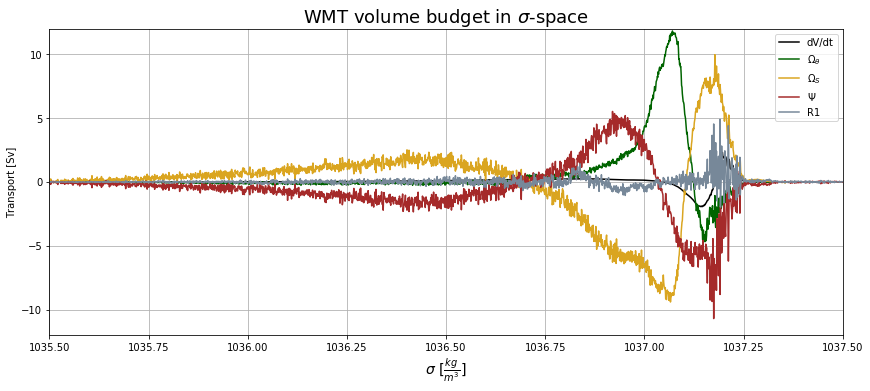

In [75]:
(dVdt/1e6).mean(dim='time').plot(label='dV/dt', color='k', figsize=(12,5))
(omega_trans_rate_th/1e6).mean(dim='time').plot(label=r'$\Omega_{\theta}$', color='darkgreen')
(omega_trans_rate_slt/1e6).mean(dim='time').plot(label=r'$\Omega_S$', color='goldenrod')
(psi_adv/1e6).mean(dim='time').plot(label=r'$\Psi$', color='brown')
(R1/1e6).mean(dim='time').plot(label='R1', color='lightslategray')
#(R3[1:-1]/1e6).mean(dim='time').plot(label=r'$R3$', color='mediumspringgreen')
plt.legend()
plt.grid()
plt.ylim(-12, 12)
plt.xlim(1035.5, 1037.5)
plt.tight_layout()
plt.xlabel(r'$\sigma$ $[\frac{kg}{m^3}]$', fontsize=14)
plt.ylabel(r'Transport [Sv]')
plt.title(r'WMT volume budget in $\sigma$-space', fontsize=18);

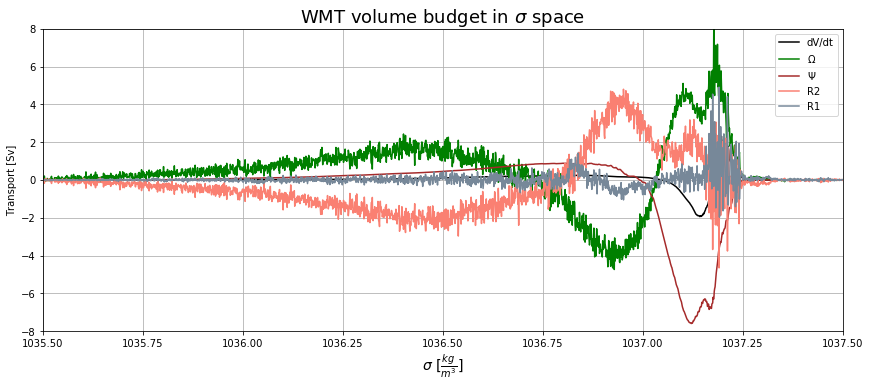

In [76]:
(dVdt/1e6).mean(dim='time').plot(label='dV/dt', color='k', figsize=(12,5))
(omega_trans_rate/1e6).mean(dim='time').plot(label=r'$\Omega$', color='green')
(psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi$', color='brown')
(R2/1e6).mean(dim='time').plot(label='R2', color='salmon')
(R1/1e6).mean(dim='time').plot(label='R1', color='lightslategray')
#(R3[1:-1]/1e6).mean(dim='time').plot(label=r'$R3$', color='mediumspringgreen')
plt.legend()
plt.grid()
plt.xlim(1035.5, 1037.5)
plt.ylim(-8, 8)
plt.tight_layout()
plt.xlabel(r'$\sigma$ $[\frac{kg}{m^3}]$', fontsize=14)
plt.ylabel(r'Transport [Sv]')
plt.title(r'WMT volume budget in $\sigma$ space', fontsize=18);

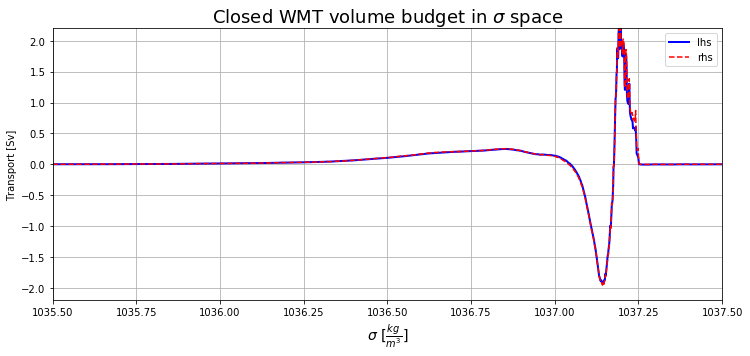

In [77]:
(dVdt/1e6).mean(dim='time').plot(label='lhs', color='blue', linewidth=2, figsize=(12,5)) 
((omega_trans_rate + psi_adv + R1)/1e6).mean(dim='time').plot(color='red', linestyle='dashed', label='rhs')
#plt.title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Omega + \Psi + R3 + R1$', fontsize=18)
plt.title(r'Closed WMT volume budget in $\sigma$ space', fontsize=18)
plt.legend()
plt.xlabel(r'$\sigma$ $[\frac{kg}{m^3}]$', fontsize=14)
plt.ylabel(r'Transport [Sv]')
plt.grid()
plt.ylim(-2.2,2.2)
plt.xlim(1035.5, 1037.5);

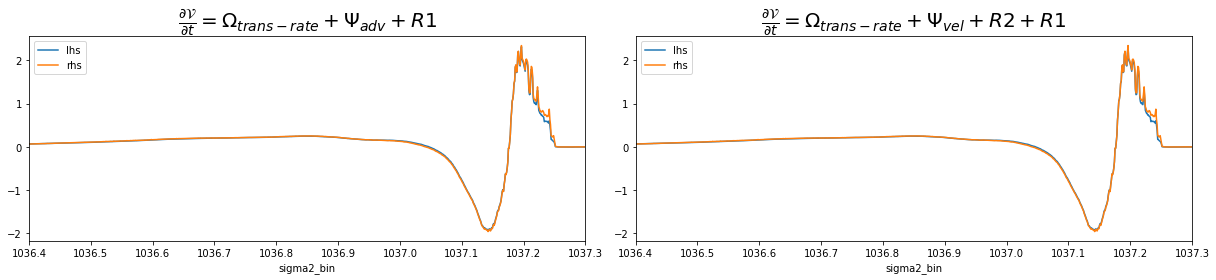

In [78]:
fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(17,4))

(dVdt/1e6).mean(dim='time').plot(label='lhs', ax=ax0) 
((omega_trans_rate + psi_adv + R1)/1e6).mean(dim='time').plot(label='rhs', ax=ax0)
ax0.set_title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Omega_{trans-rate} + \Psi_{adv} + R1$', fontsize=20, fontweight='bold')
ax0.legend()
ax0.set_xlim(1036.4, 1037.3)

(dVdt/1e6).mean(dim='time').plot(label='lhs', ax=ax1) 
((omega_trans_rate + R1 + psi_vel + R2)/1e6).mean(dim='time').plot(label='rhs', ax=ax1)
ax1.set_title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Omega_{trans-rate} + \Psi_{vel} + R2 + R1$', fontsize=20, fontweight='bold')
ax1.legend()
ax1.set_xlim(1036.4, 1037.3)

plt.tight_layout();

## Breaking up $\Omega_{trans-rate}$ term

In [79]:
omega_mix_th = (- (all_dsets_th.OMEGA_conv_horiz_diff_flux_TH + 
                  all_dsets_th.OMEGA_conv_vert_diff_flux_TH)).load()
omega_surf_th = (-(all_dsets_th.OMEGA_sw_flux_conv_TH + 
                  all_dsets_th.OMEGA_surface_flux_conv_TH)).load()

omega_mix_slt = (- (all_dsets_slt.OMEGA_conv_horiz_diff_flux_SLT + 
                   all_dsets_slt.OMEGA_conv_vert_diff_flux_SLT +
                   all_dsets_slt.OMEGA_salt_plume)).load()
omega_surf_slt = (- all_dsets_slt.OMEGA_surface_flux_SLT).load()

omega_mix = (omega_mix_th + omega_mix_slt).load()
omega_surf = (omega_surf_th + omega_surf_slt).load()

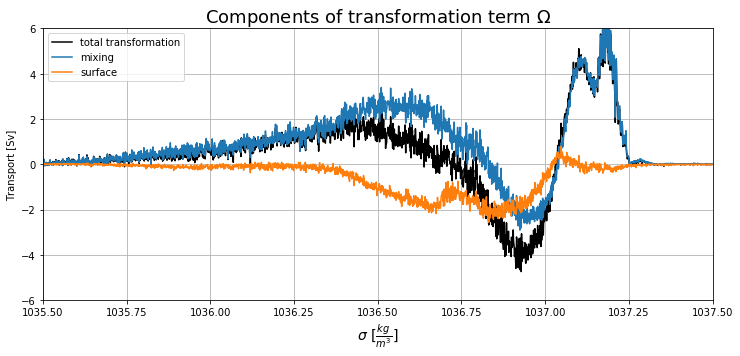

In [80]:
(omega_trans_rate/1e6).mean(dim='time').plot(figsize=(12,5), label='total transformation', color='k')
(omega_mix/1e6).mean(dim='time').plot(label='mixing')
(omega_surf/1e6).mean(dim='time').plot(label='surface')
plt.legend()
plt.grid()
plt.xlim(1035.5, 1037.5)
plt.ylim(-6, 6)
plt.xlabel(r'$\sigma$ $[\frac{kg}{m^3}]$', fontsize=14)
plt.ylabel(r'Transport [Sv]')
plt.title(r'Components of transformation term $\Omega$', fontsize=18);

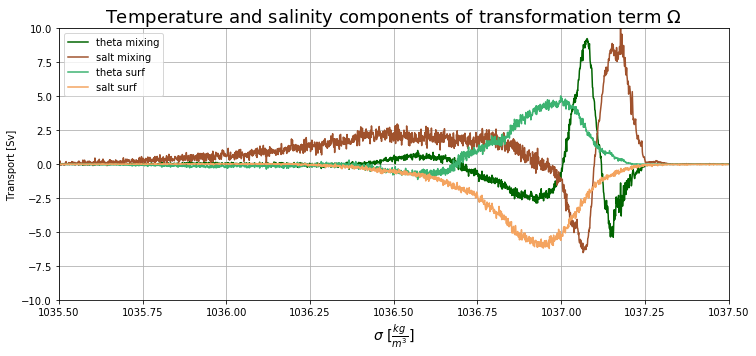

In [81]:
(omega_mix_th/1e6).mean(dim='time').plot(figsize=(12,5), label='theta mixing', color='darkgreen')
(omega_mix_slt/1e6).mean(dim='time').plot(label='salt mixing', color='sienna')
(omega_surf_th/1e6).mean(dim='time').plot(label='theta surf', color='mediumseagreen')
(omega_surf_slt/1e6).mean(dim='time').plot(label='salt surf', color='sandybrown')
plt.legend()
plt.grid()
plt.xlim(1035.5, 1037.5)
plt.ylim(-10, 10)
plt.xlabel(r'$\sigma$ $[\frac{kg}{m^3}]$', fontsize=14)
plt.ylabel(r'Transport [Sv]')
plt.title(r'Temperature and salinity components of transformation term $\Omega$', fontsize=18);

## Timeseries of AABW, CDW, HSSW

In [82]:
aabw_bin = dict(sigma2_bin=1037.199, method='nearest')
cdw_bin = dict(sigma2_bin=1037.118, method='nearest')
hsw_bin = dict(sigma2_bin=1037.357, method='nearest')

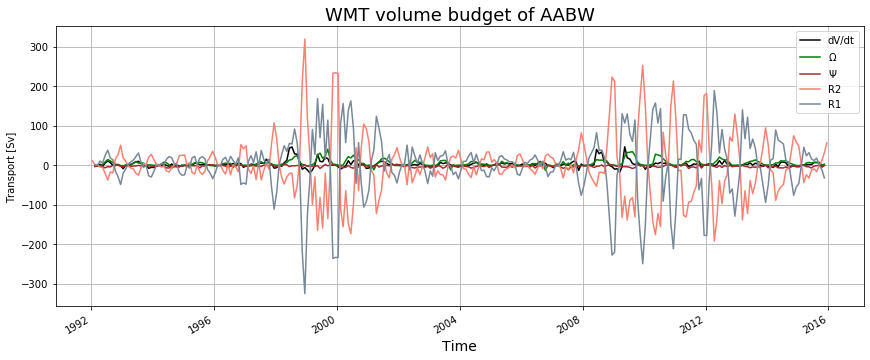

In [83]:
(dVdt/1e6).sel(**aabw_bin).plot(label='dV/dt', color='k', figsize=(12,5))
(omega_trans_rate/1e6).sel(**aabw_bin).plot(label=r'$\Omega$', color='green')
(psi_vel/1e6).sel(**aabw_bin).plot(label=r'$\Psi$', color='brown')
(R2/1e6).sel(**aabw_bin).plot(label='R2', color='salmon')
(R1/1e6).sel(**aabw_bin).plot(label='R1', color='lightslategray')
plt.legend()
plt.grid()
#plt.xlim(1035.5, 1037.5)
#plt.ylim(-8, 8)
plt.tight_layout()
plt.xlabel(r'Time', fontsize=14)
plt.ylabel(r'Transport [Sv]')
plt.title(r'WMT volume budget of AABW', fontsize=18);

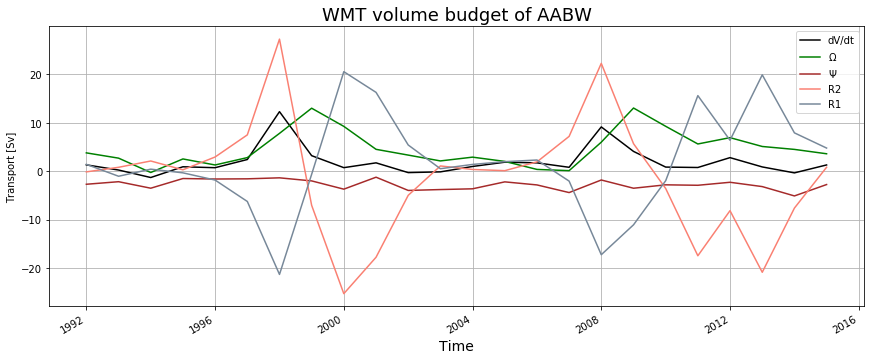

In [88]:
(dVdt/1e6).sel(**aabw_bin).resample(time='AS').mean(dim='time').plot(x='time', label='dV/dt', color='k', figsize=(12,5))
(omega_trans_rate/1e6).sel(**aabw_bin).resample(time='AS').mean(dim='time').plot(x='time', label=r'$\Omega$', color='green')
(psi_vel/1e6).sel(**aabw_bin).resample(time='AS').mean(dim='time').plot(x='time', label=r'$\Psi$', color='brown')
(R2/1e6).sel(**aabw_bin).resample(time='AS').mean(dim='time').plot(x='time', label='R2', color='salmon')
(R1/1e6).sel(**aabw_bin).resample(time='AS').mean(dim='time').plot(x='time', label='R1', color='lightslategray')
plt.legend()
plt.grid()
#plt.xlim(1035.5, 1037.5)
#plt.ylim(-8, 8)
plt.tight_layout()
plt.xlabel(r'Time', fontsize=14)
plt.ylabel(r'Transport [Sv]')
plt.title(r'WMT volume budget of AABW', fontsize=18);

In [90]:
sigma_bins.size

10000

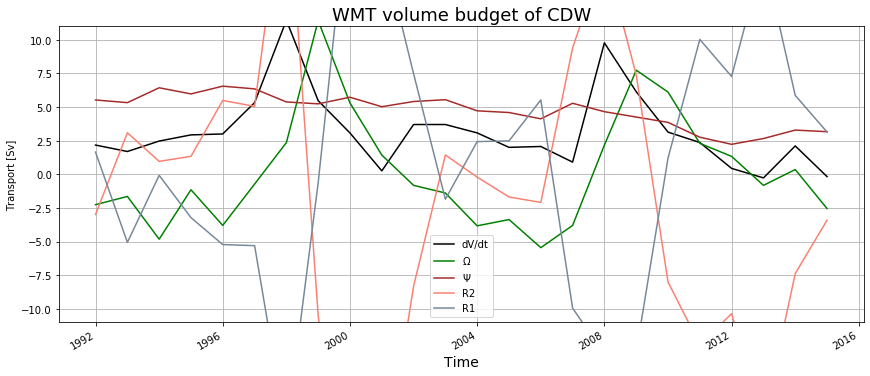

In [85]:
((dVdt.sel(**aabw_bin) - dVdt.sel(**cdw_bin))/1e6).resample(time='AS').mean(dim='time').plot(x='time', 
                                                                                             label='dV/dt', color='k', figsize=(12,5))
((omega_trans_rate.sel(**aabw_bin) - omega_trans_rate.sel(**cdw_bin))/1e6).resample(time='AS').mean(dim='time').plot(x='time', 
                                                                                                                     label=r'$\Omega$', color='green')
((psi_vel/1e6).sel(**aabw_bin) - (psi_vel/1e6).sel(**cdw_bin)).resample(time='AS').mean(dim='time').plot(x='time', 
                                                                                                         label=r'$\Psi$', color='brown')
((R2/1e6).sel(**aabw_bin) - (R2/1e6).sel(**cdw_bin)).resample(time='AS').mean(dim='time').plot(x='time', 
                                                                                               label='R2', color='salmon')
((R1/1e6).sel(**aabw_bin) - (R1/1e6).sel(**cdw_bin)).resample(time='AS').mean(dim='time').plot(x='time', 
                                                                                               label='R1', color='lightslategray')
plt.legend()
plt.grid()
#plt.xlim(1035.5, 1037.5)
plt.ylim(-11, 11)
plt.tight_layout()
plt.xlabel(r'Time', fontsize=14)
plt.ylabel(r'Transport [Sv]')
plt.title(r'WMT volume budget of CDW', fontsize=18);

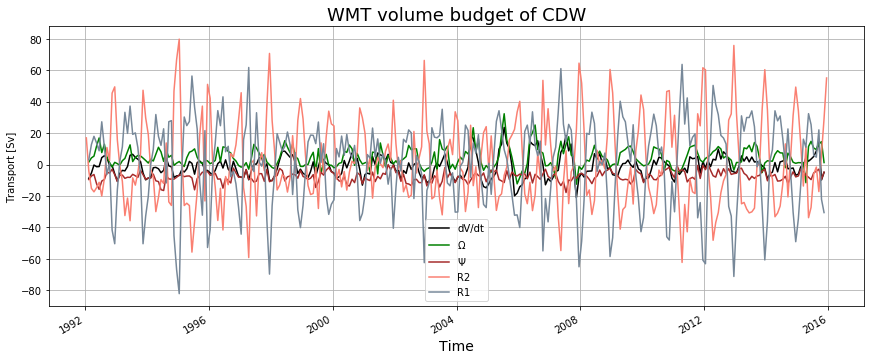

In [86]:
(dVdt/1e6).sel(**cdw_bin).plot(label='dV/dt', color='k', figsize=(12,5))
(omega_trans_rate/1e6).sel(**cdw_bin).plot(label=r'$\Omega$', color='green')
(psi_vel/1e6).sel(**cdw_bin).plot(label=r'$\Psi$', color='brown')
(R2/1e6).sel(**cdw_bin).plot(label='R2', color='salmon')
(R1/1e6).sel(**cdw_bin).plot(label='R1', color='lightslategray')
plt.legend()
plt.grid()
#plt.xlim(1035.5, 1037.5)
#plt.ylim(-8, 8)
plt.tight_layout()
plt.xlabel(r'Time', fontsize=14)
plt.ylabel(r'Transport [Sv]')
plt.title(r'WMT volume budget of CDW', fontsize=18);

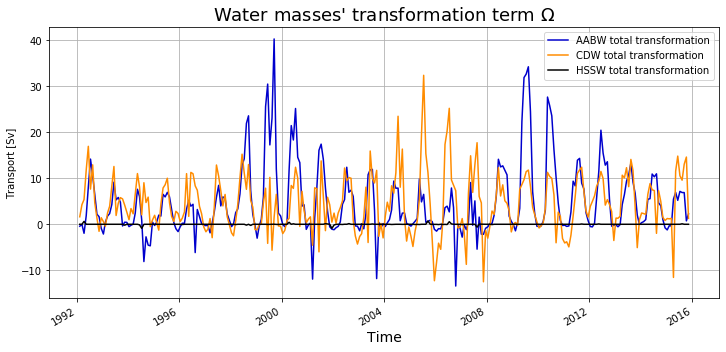

In [87]:
(omega_trans_rate/1e6).sel(**aabw_bin).plot(figsize=(12,5), label='AABW total transformation', color='mediumblue')
(omega_trans_rate/1e6).sel(**cdw_bin).plot(label='CDW total transformation', color='darkorange')
(omega_trans_rate/1e6).sel(**hsw_bin).plot(label='HSSW total transformation', color='k')
plt.legend()
plt.grid()
#plt.xlim(1035.5, 1037.5)
#plt.ylim(-6, 6)
plt.xlabel(r'Time', fontsize=14)
plt.ylabel(r'Transport [Sv]')
plt.title(r"Water masses' transformation term $\Omega$", fontsize=18);